# Introduction
There are some interesting facts that this competition attracts me.
- Data size is very large:240 million rows
- Imbalanced data
- Use ROC-AUC as performance metrics
- Real life problem

# Data EDA
refer to those solutions
https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56283

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56328

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56268

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56406

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56325

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56481

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56429

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56422

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56475#latest-436248

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/56262#latest-517655

# Load Data

In [110]:
import gc
import os
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

## Check File Size

In [144]:
def check_fsize(dpath,s=30):
    """check file size
    Args:
    dpath: file directory
    s: string length in total after padding
    
    Returns:
    None
    """
    for f in os.listdir(dpath):
        print(f.ljust(s) + str(round(os.path.getsize(dpath+'/' + f) / 1000000, 2)) + 'MB')

In [145]:
check_fsize('./data')

sample_submission.csv.zip     41.74MB
test_supplement.csv.zip       528.08MB
test.csv                      863.27MB
train_sample.csv.zip          1.13MB
train.csv                     7537.65MB
test.csv.zip                  173.03MB
train.csv.zip                 1298.59MB
train_sample.csv              4.08MB
test_supplement.csv           2665.54MB
.ipynb_checkpoints            0.0MB


In [146]:
def check_fline(fpath):
    """check total number of lines of file for large files
    
    Args:
    fpath: string. file path
    
    Returns:
    None
    
    """
    lines = subprocess.run(['wc', '-l', fpath], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines, end='', flush=True)

In [149]:
fs=['./data/train.csv', './data/test.csv', './data/train_sample.csv']
[check_fline(s) for s in fs]

184903891 ./data/train.csv
18790470 ./data/test.csv
100001 ./data/train_sample.csv


[None, None, None]

Total line number is huge so just load 1 million row of data for analysis

## Load Data

In [105]:
# Load sample training data
df_train = pd.read_csv('./data/train.csv', nrows=1000000, parse_dates=['click_time'])
df_test = pd.read_csv('./data/test.csv', nrows=1000000, parse_dates=['click_time'])

# Show head
print(df_train.head())

# show shape
print(df_test.head())

       ip  app  device  os  channel          click_time attributed_time  \
0   83230    3       1  13      379 2017-11-06 14:32:21             NaN   
1   17357    3       1  19      379 2017-11-06 14:33:34             NaN   
2   35810    3       1  13      379 2017-11-06 14:34:12             NaN   
3   45745   14       1  13      478 2017-11-06 14:34:52             NaN   
4  161007    3       1  13      379 2017-11-06 14:35:08             NaN   

   is_attributed  
0              0  
1              0  
2              0  
3              0  
4              0  
   click_id      ip  app  device  os  channel          click_time
0         0    5744    9       1   3      107 2017-11-10 04:00:00
1         1  119901    9       1   3      466 2017-11-10 04:00:00
2         2   72287   21       1  19      128 2017-11-10 04:00:00
3         3   78477   15       1  13      111 2017-11-10 04:00:00
4         4  123080   12       1  13      328 2017-11-10 04:00:00


- Values are encoded

## Check feature unique value

In [167]:
def check_cunique(df,cols):
    """check unique values for each column
    df: data frame. 
    cols: list. The columns of data frame to be counted
    """
    df_nunique = df[cols].nunique().to_frame()
    df_nunique = df_nunique.reset_index().rename(columns={'index': 'feat',0:'nunique'})
    return df_nunique

In [168]:
df_nunique = check_cunique(df_train,['ip', 'app', 'device', 'os', 'channel'])
df_nunique

,feat,nunique
0,ip,39611
1,app,214
2,device,298
3,os,160
4,channel,154


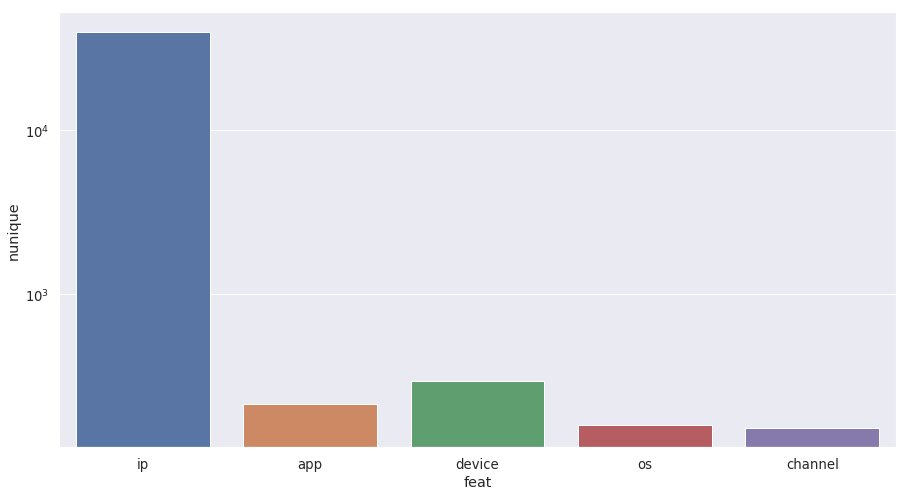

In [132]:
plt.figure(figsize=(15, 8))
sns.set(font_scale=1.2)
sns.barplot(x="feat" ,y="nunique", data=df_nunique,log=True)

In [219]:
def feat_value_count(df,colname):
    """value count of each feature
    
    Args
    df: data frame.
    colname: string. Name of to be valued column
    
    Returns
    df_count: data frame.
    """
    df_count = df[colname].value_counts().to_frame().reset_index()
    df_count = df_count.rename(columns={'index':colname+'_values',colname:'counts'})
    return df_count

In [220]:
feat_value_count(df_train,'is_attributed')

,is_attributed_values,counts
0,0,998307
1,1,1693


In [221]:
feat_value_count(df_train,'app').head()

,app_values,counts
0,12,141851
1,3,136810
2,15,114425
3,2,114340
4,9,112038


## Check missing value

In [196]:
def check_missing(df,cols=None,axis=0):
    """check data frame column missing situation
    Args
    df: data frame.
    cols: list. List of column names
    
    Returns
    missing_info: data frame. 
    """
    if cols != None:
        df = df[cols]
    missing_num = df.isnull().sum(axis).to_frame().rename(columns={0:'missing_num'})
    missing_num['minssing_percent'] = df.isnull().mean(axis)*100
    return missing_num.sort_values(by='minssing_percent',ascending = False) 

In [199]:
print(check_missing(df_train))
print(check_missing(df_train,axis=1).head())

                 missing_num  minssing_percent
attributed_time       998307           99.8307
ip                         0            0.0000
app                        0            0.0000
device                     0            0.0000
os                         0            0.0000
channel                    0            0.0000
click_time                 0            0.0000
is_attributed              0            0.0000
day                        0            0.0000
hour                       0            0.0000
minute                     0            0.0000
second                     0            0.0000
        missing_num  minssing_percent
0                 1          8.333333
666431            1          8.333333
666403            1          8.333333
666404            1          8.333333
666405            1          8.333333


# Time Feature

First extract day, minute, hour, second from the click_time.

In [7]:
X_train['day'] = X_train['click_time'].dt.day.astype('uint8')
X_train['hour'] = X_train['click_time'].dt.hour.astype('uint8')
X_train['minute'] = X_train['click_time'].dt.minute.astype('uint8')
X_train['second'] = X_train['click_time'].dt.second.astype('uint8')
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9


# Confidence Feature

Some ips, apps, devices, etc. might have higher frequencies of is_attributed

In [69]:
cats =['ip', 'app', 'device', 'os', 'channel'] 
# Find frequency of is_attributed for each category
freqs = {}
for cols in cats:
    
    # New feature name
    new_feat = cols + '_confRate'    
    
    # Perform the groupby
    group_object = X_train.groupby(cols)
    
    # category attribution
    cat_atrributed = group_object['is_attributed'].sum()
    
    # category views
    cat_counts = group_object['is_attributed'].count()
    
    # category attribution rates
    cat_rates = cat_atrributed/cat_counts
    
    # attributuion confidence level
    cat_confs = np.log(cat_counts+1)/np.log(100000) # 1000 views -> 60% confidence, 100 views -> 40% confidence 
    cat_confs = [min(1,x) for x in cat_confs]
    # category final attribution
    cat_score = cat_rates * cat_confs
    cat_score = cat_score.to_frame().reset_index().rename(index=str, columns={'is_attributed': new_feat})
    
    # merge
    X_train = X_train.merge(cat_score,on=cols, how='left')

In [70]:
X_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,ip_confRate,app_confRate,device_confRate,os_confRate,channel_confRate
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0,7,9,30,38,0.0,0.000062,0.00154,0.001019,0.0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0,7,13,40,27,0.0,0.000000,0.00154,0.000853,0.0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0,7,18,5,24,0.0,0.000062,0.00154,0.001504,0.0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0,7,4,58,8,0.0,0.000000,0.00154,0.001019,0.0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0,9,9,0,9,0.0,0.000062,0.00154,0.000519,0.0


In [71]:
X_train.shape

(100000, 17)